# Exploring the Risk Classification of Business Firms Based on Discrepancies in Past Audits

### **Introduction**

Audit is defined as the process of evaluating a business’ financial statements to ensure that these records concur with the expectations of standard accounting laws. The ability to detect fraudulent activity in a firm (i.e. a business) which may warrant an audit is essential to modern-day, efficient audit management. In this investigation, we will attempt to answer a **predictive** question with **classification** based on various audit risk factors such as: Given a firm’s amount of money involved in misstatements in past audits (“Money_Value” [Crore]) and total amount of discrepancies found in other reports (“TOTAL” [Crore]), can we accurately predict a firm’s appropriate Risk Class: “Fraud” or “No-fraud?” 

The “Audit Data” dataset will be used to answer this question. This dataset contains various predictors about 777 Indian firms over a one-year period from 2015 to 2016, cataloging past and present historical audit risk factors. A classification model can be built upon the two selected factors to predict and identify potentially fraudulent firms.

To expand upon our selected predictors: the variable “TOTAL” represents the total amount of discrepancies found in other reports (i.e. the sum of “PARA_A” and “PARA_B” scores, which are discrepancies in planned and unplanned expenditures, respectively). The variable “Money_Value” represents the amount of money involved in misstatements of past audits. Both of these indicators deal with firms’ past mismanaged or missing money and, as such, we feel they make excellent predictors for the classification of Risk Class. Risk Class is a binary categorical variable where the “Fraud” class is represented by “Risk = 1” and the “No-fraud” class is represented by “Risk = 0.” In context, firms that fall within the “Fraud” class are considered to warrant significant investigation. If a future firm were to be examined, by looking at their past audits and discrepancies through the model proposed herein, we can classify it as a potential “Fraud” or “No-Fraud” Risk. 


### **Exploratory Data Analysis**

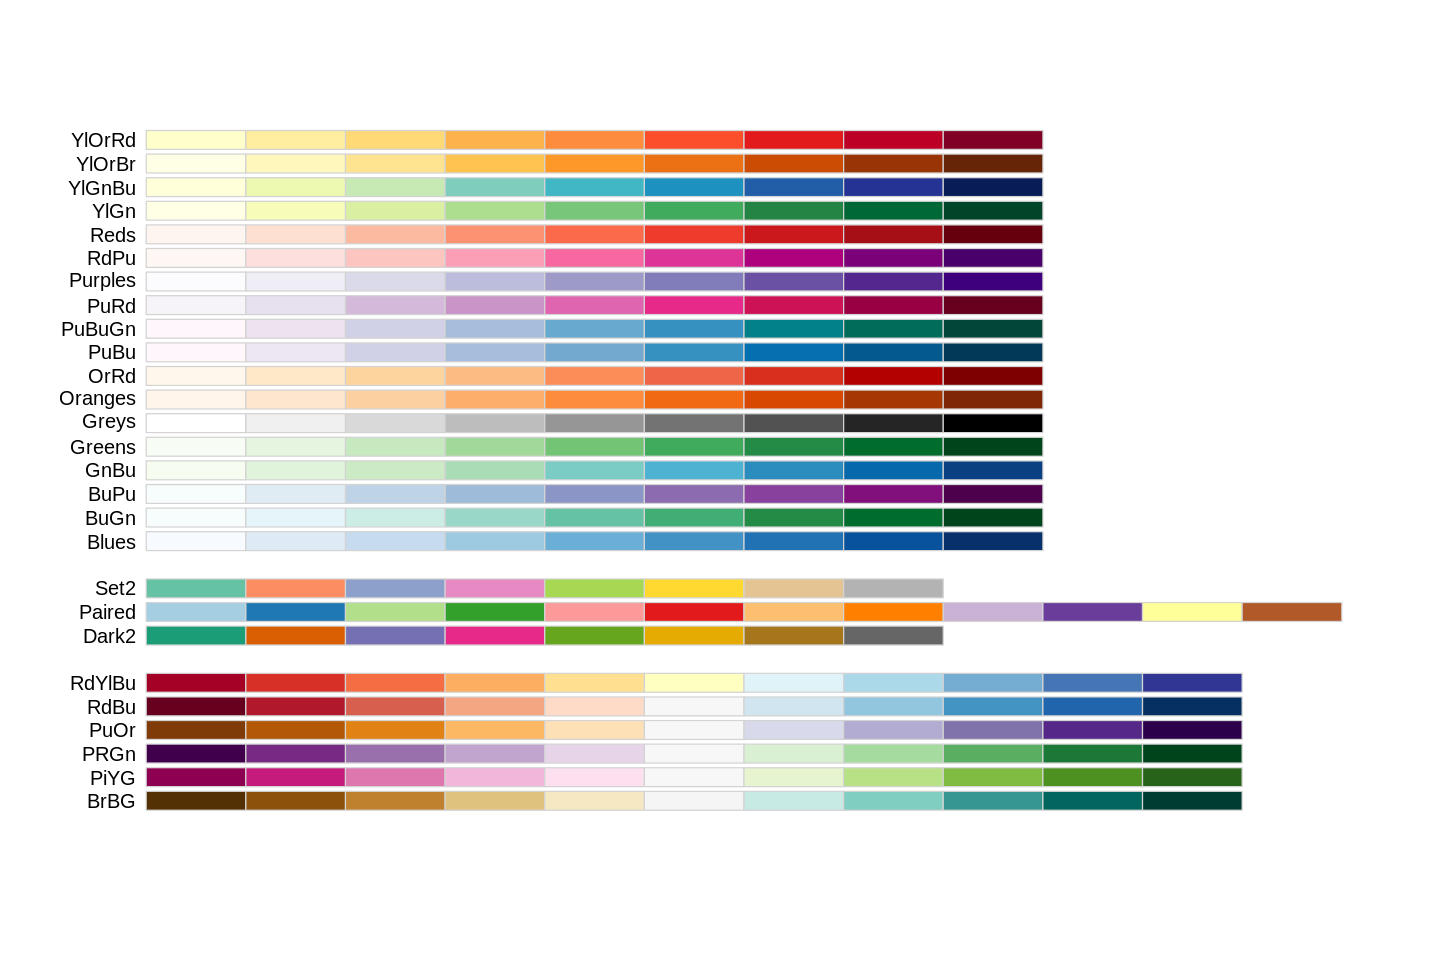

In [8]:
library(tidyverse)
library(repr)
library(tidymodels)
library(scales)
library(RColorBrewer)
options(repr.matrix.max.rows = 6)
# Ensure the Palette used is colour blind friendly
display.brewer.all(colorblindFriendly = TRUE)

Parsed with column specification:
cols(
  Sector_score = col_double(),
  LOCATION_ID = col_character(),
  PARA_A = col_double(),
  SCORE_A = col_double(),
  PARA_B = col_double(),
  SCORE_B = col_double(),
  TOTAL = col_double(),
  numbers = col_double(),
  Marks = col_double(),
  Money_Value = col_double(),
  MONEY_Marks = col_double(),
  District = col_double(),
  Loss = col_double(),
  LOSS_SCORE = col_double(),
  History = col_double(),
  History_score = col_double(),
  Score = col_double(),
  Risk = col_double()
)

`summarise()` ungrouping output (override with `.groups` argument)



Risk,count,percentage
<fct>,<int>,<dbl>
Fraud,486,62.62887
No Fraud,290,37.37113


Warning message:
“Transformation introduced infinite values in continuous x-axis”
Warning message:
“Transformation introduced infinite values in continuous y-axis”
Warning message:
“Removed 1 rows containing missing values (geom_point).”


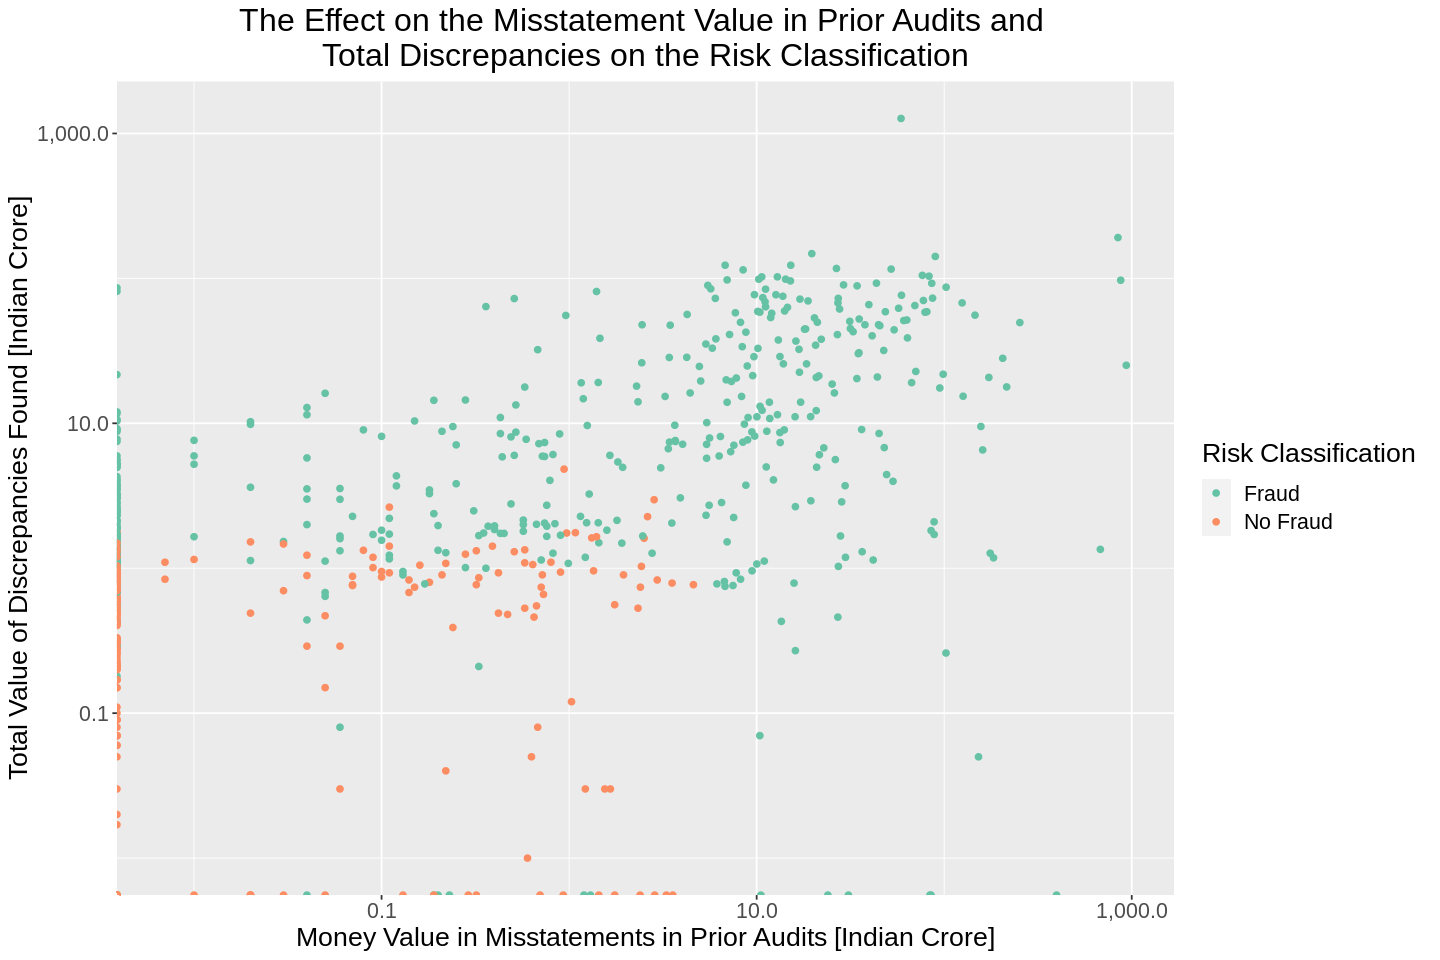

In [9]:
# Set seed to ensure randomness
set.seed(1001)

# Loading the Dataset
url = "https://raw.githubusercontent.com/fulleraltamiranoe/audit_data/main/trial.csv"
audit_trial_data <- read_csv(url) 

# Changing the Risk Classification to meaningful names
audit_trial_data$Risk <- ifelse(audit_trial_data$Risk == "1", "Fraud", "No Fraud")

# Treat Risk as factor
audit_trial_data <- audit_trial_data %>%
    mutate(Risk = as_factor(Risk))

# Group by Risk and Summarize to see how the Risk classification is ditributed
count <- audit_trial_data %>%
    group_by(Risk) %>%
    summarize(count = n(), percentage = n() / nrow(audit_trial_data) * 100)
count

# Visualizing original data utilizing a log scale
options(repr.plot.width = 12, repr.plot.height = 8) 
audit_original_plot <- audit_trial_data %>%
    ggplot(aes(x = Money_Value, y = TOTAL, colour = Risk)) +
    geom_point() +
    labs(x = "Money Value in Misstatements in Prior Audits [Indian Crore]", 
         y = "Total Value of Discrepancies Found [Indian Crore]", 
         colour = "Risk Classification") +
    ggtitle("The Effect on the Misstatement Value in Prior Audits and \nTotal Discrepancies on the Risk Classification") +
    theme(text = element_text(size = 16), plot.title = element_text(hjust = 0.5)) +
    scale_x_log10(labels = label_comma()) +
    scale_y_log10(labels = label_comma()) +
    scale_color_brewer(palette = "Set2")
audit_original_plot

In [10]:
# Cleaning the dataset and keeping predictors we will use
# From the above visualization, we can see that most firms
# are considered Fraud, we will balance the data set
audit <- audit_trial_data %>%
    select(Money_Value, TOTAL, Risk) 
audit

# showcasing inbalance
count <- audit %>%
    group_by(Risk) %>%
    summarize(count = n(), percentage = n() / nrow(audit_trial_data) * 100)
count

# As mentioned above, Fraud data is over represented. Balancing original data
audit_recipe_balance <- recipe(Risk ~ TOTAL + Money_Value, data = audit) %>%
    step_upsample(Risk, over_ratio = 1, skip = FALSE) %>%
    prep()

# Balanced data
upsampled_audit <- bake(audit_recipe_balance, audit)

upsampled_count <- upsampled_audit %>%
    group_by(Risk) %>%
    summarize(count = n(), percentage = n() / nrow(audit_trial_data) * 100)
upsampled_count

Money_Value,TOTAL,Risk
<dbl>,<dbl>,<fct>
3.38,6.68,Fraud
0.94,4.83,No Fraud
0.00,0.74,No Fraud
⋮,⋮,⋮
0.00,0.28,No Fraud
0.00,0.20,No Fraud
0.32,0.00,No Fraud


`summarise()` ungrouping output (override with `.groups` argument)



Risk,count,percentage
<fct>,<int>,<dbl>
Fraud,486,62.62887
No Fraud,290,37.37113


`summarise()` ungrouping output (override with `.groups` argument)



Risk,count,percentage
<fct>,<int>,<dbl>
Fraud,486,62.62887
No Fraud,486,62.62887


x Fold1: model 1/1 (predictions): Error: Problem with `mutate()` input `.row`.
[...

x Fold2: model 1/1 (predictions): Error: Problem with `mutate()` input `.row`.
[...



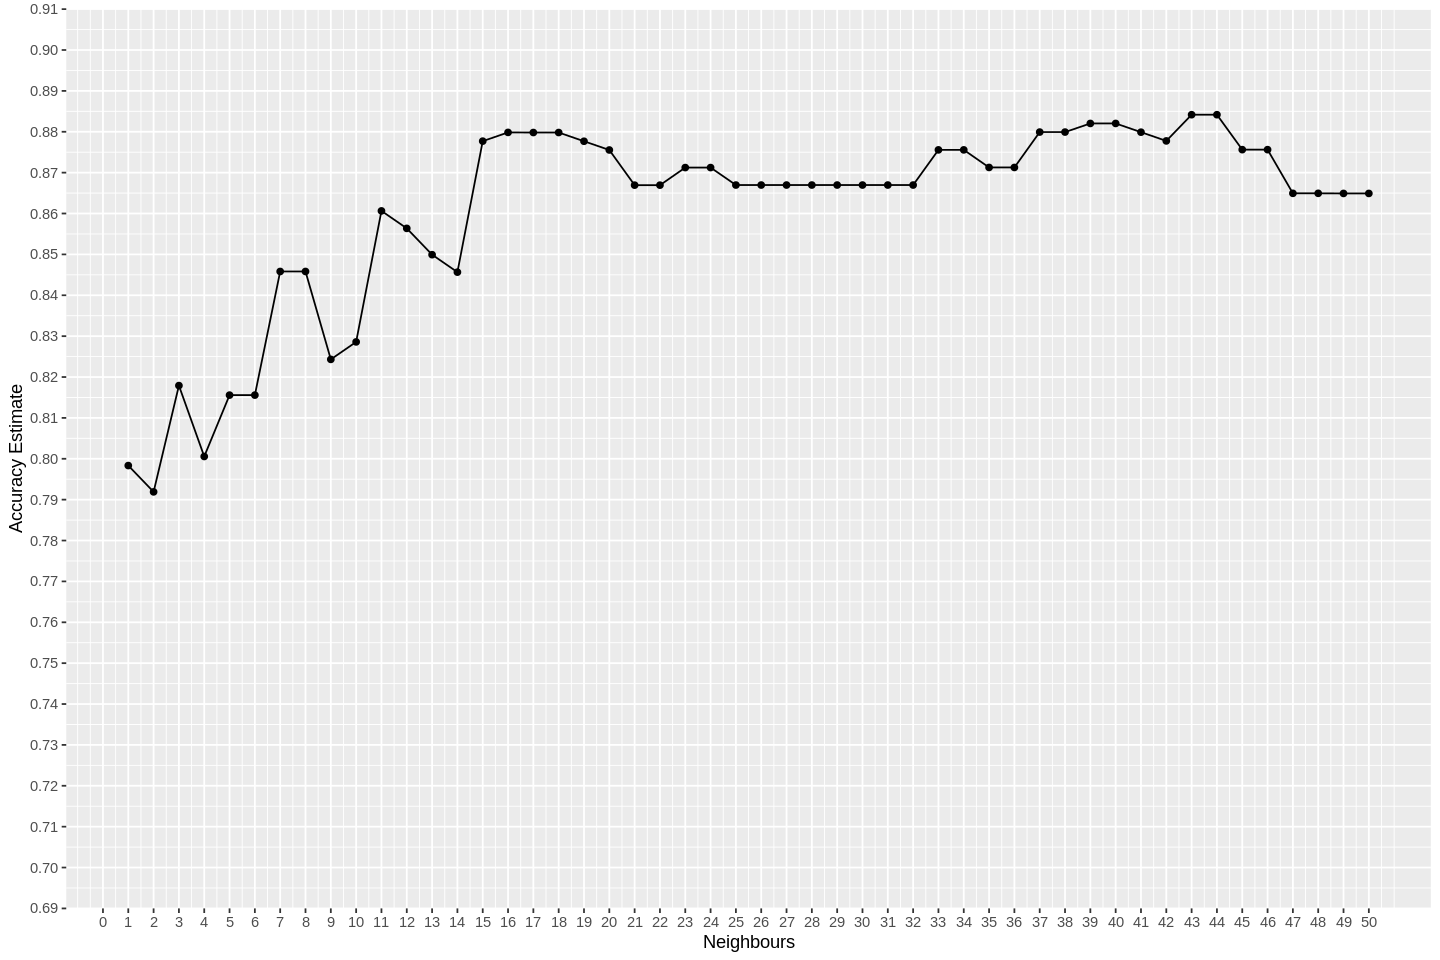

In [11]:
# Splitting data into training and testing sets, 80% training data to ensure as much accuracy in 
# our model as possible.
audit_split <- initial_split(upsampled_audit, prop = 0.8, strata = Risk)  
audit_train <- training(audit_split)   
audit_test <- testing(audit_split)

# Training with our predictors
audit_recipe <- recipe(Risk ~ TOTAL + Money_Value, data = audit_train) %>%
    step_scale(all_predictors())%>%
    step_center(all_predictors())

# tuning, determine how many neighbours to use
knn_tune <- nearest_neighbor(weight_func = 'rectangular', neighbors = tune()) %>%
    set_engine('kknn') %>%
    set_mode('classification')

audit_vfold <- vfold_cv(audit_train, v = 5, strata = Risk)

# Multiple maximum values of K were tested, after 50 running the code takes too long and 
# there's no significant increase in accuracy
k_vals <- tibble(neighbors = seq(from = 1, to = 50, by = 1))

knn_results <- workflow() %>%
    add_recipe(audit_recipe) %>%
    add_model(knn_tune) %>%
    tune_grid(resamples = audit_vfold, grid = k_vals) %>%
    collect_metrics()

accuracies <- knn_results %>% 
    filter(.metric == 'accuracy')

# Visualizing the accuracy of each value of K to choose the best possibe one
accuracy_versus_k <- ggplot(accuracies, aes(x = neighbors, y = mean)) +
    geom_point() +
    geom_line() +
    labs(x = "Neighbours", y = "Accuracy Estimate") + 
    scale_x_continuous(limits = c(1, 50), breaks = seq(0, 50, by = 1)) +  # adjusting the x-axis
    scale_y_continuous(limits = c(0.7, 0.9), breaks = seq(0, 1, by = 0.01)) # adjusting the y-axis

accuracy_versus_k 

In [12]:
# K = 43 seems to be the most accurate, re-train with this value of K
audit_knn_spec <- nearest_neighbor(weight_func = 'rectangular', neighbors = 43) %>%
    set_engine('kknn') %>%
    set_mode('classification')

# Fitting our data
audit_fit <- workflow() %>%
    add_recipe(audit_recipe) %>%
    add_model(audit_knn_spec) %>%
    fit(data = audit_train)

# Testing the accuracy of our model with our testing data 
audit_test_predictions <- predict(audit_fit, audit_test) %>%
    bind_cols(audit_test)

predictions_accuracy <- audit_test_predictions %>%
    metrics(truth = Risk, estimate = .pred_class)             
predictions_accuracy

# Creating a confusion matrix
audit_mat <- audit_test_predictions %>% 
    conf_mat(truth = Risk, estimate = .pred_class)   
audit_mat

.metric,.estimator,.estimate
<chr>,<chr>,<dbl>
accuracy,binary,0.9072165
kap,binary,0.8144330


          Truth
Prediction Fraud No Fraud
  Fraud       90       11
  No Fraud     7       86

Name,Money_Value,TOTAL
<chr>,<dbl>,<dbl>
Suspicious Firm 1 (F1),1.0,1.3
Suspicious Firm 2 (F2),0.1,1.2


Warning message:
“Transformation introduced infinite values in continuous x-axis”
Warning message:
“Transformation introduced infinite values in continuous y-axis”
Warning message:
“Removed 1 rows containing missing values (geom_point).”


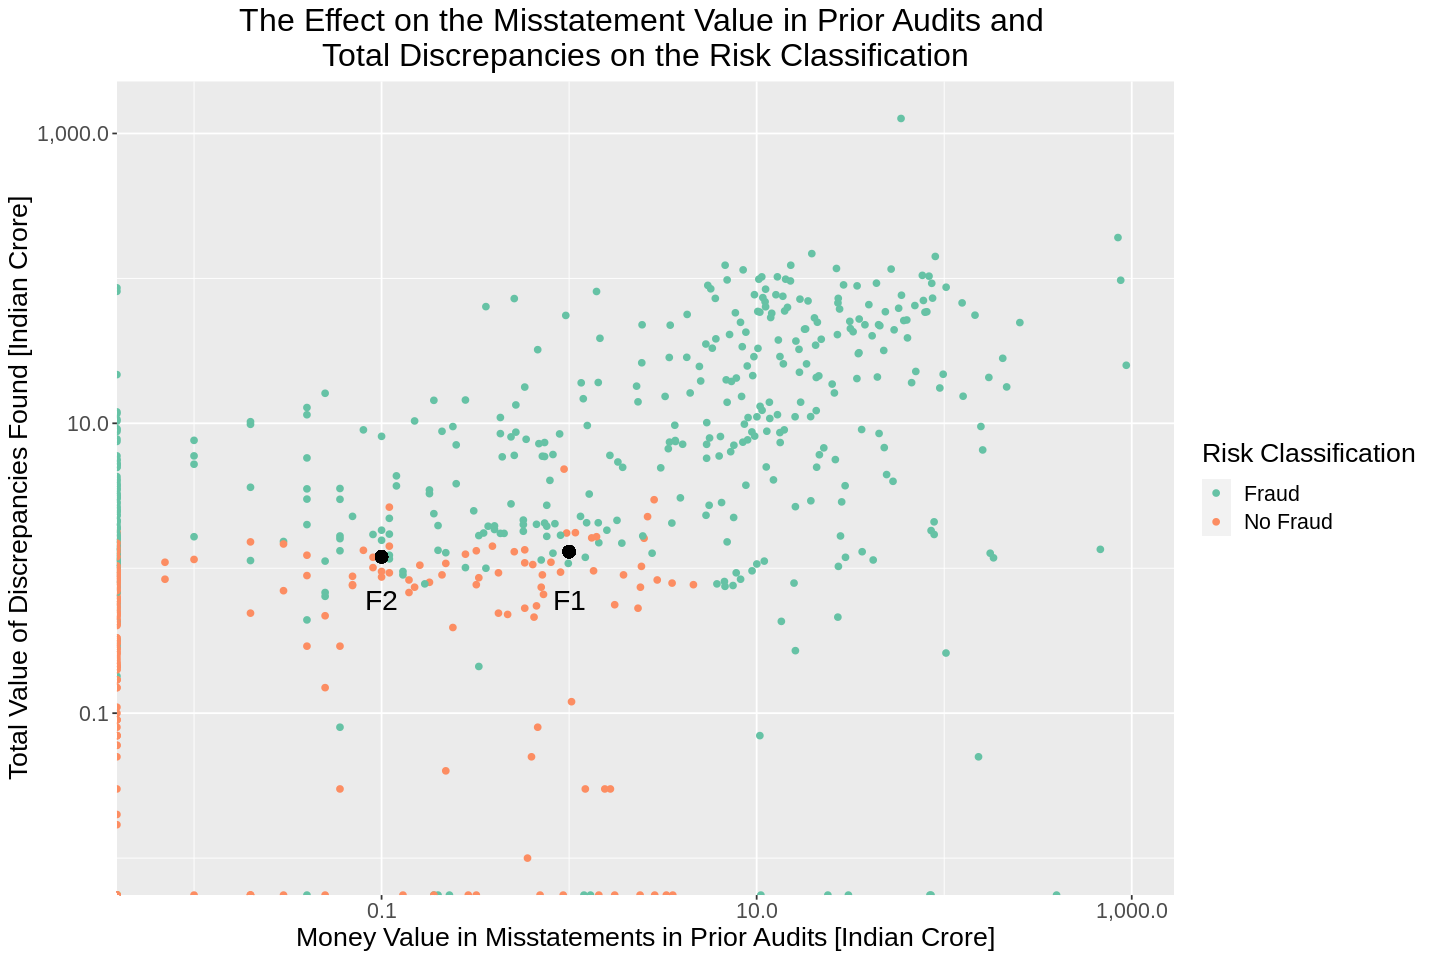

In [14]:
# Visualizing our model with two brand new supicious firms
suspicious_firms <- tibble(Name = c('Suspicious Firm 1 (F1)', 'Suspicious Firm 2 (F2)'), Money_Value = c(1, 0.1), TOTAL = c(1.3, 1.2)) 
suspicious_firms

audit_original_plot + 
    geom_point(aes(x = 1, y = 1.3), color = "black", size = 3) +
    geom_point(aes(x = 0.1, y = 1.2), color = "black", size = 3) +
    annotate("text", x = 1, y = 0.6, label = "F1", size = 6) +
    annotate("text", x = 0.1, y = 0.6, label = "F2", size = 6) 

In [15]:
# Testing our model with these two new firms
suspicious_prediction <- predict(audit_fit, suspicious_firms) %>%
    bind_cols(suspicious_firms)
suspicious_prediction

.pred_class,Name,Money_Value,TOTAL
<fct>,<chr>,<dbl>,<dbl>
No Fraud,Suspicious Firm 1 (F1),1.0,1.3
Fraud,Suspicious Firm 2 (F2),0.1,1.2


### **Methods**

In order to predict the Risk Class category of firms, the K-nearest neighbours classification algorithm will be used. A model specification will be specified by adjusting for the number of neighbours based on the accuracy estimate, ensuring the utilization of scaled data, and the straight-line distance. 

The specification will then be fitted with the training data set and Risk specified as the target utilizing both “TOTAL” and “Money_Value” as predictors. 

Note that the risk classification of “Fraud” (Risk = 1) is vastly over-represented in the original data. Creating a recipe to oversample the “No Fraud” (Risk = 0) classification could get around this. What has been done so far for the purposes of this preliminary analysis is to filter out any value over 10 for both “TOTAL” and “Money_Value” as it was noticed in the original data that all of these values were classified as “Fraud”. This also ensured that the training and testing datasets had a similar number of both classifications. 


To visualize the results, hypothetical examples of new firms with new discrepancy values will be overlaid in our visualization above to test the effectiveness of our model.

### **Expected Outcomes and Significance**

Within this classification evaluation, we will use two risk factors as predictors (“Money_Value” and “TOTAL”) to determine whether the given firms classify for either potential fraud or non fraud risk. We expect “Risk” to be accurately predicted by our model. This classification will help suggest which firms should be inspected more closely by the financial authorities in the future. The future direction of this data set would be to confirm the Risk classification, are the identified “Fraud” firms actually partaking in fraudulent activities?

### **References**

Nishtha Hooda, Seema Bawa & Prashant Singh Rana (2018) Fraudulent Firm Classification: A Case Study of an External Audit, Applied Artificial Intelligence, 32:1, 48-64, DOI: 10.1080/08839514.2018.1451032